# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv'.format(400))
df.Date = pd.to_datetime(df.Date, format = '%Y-%m-%d')
df = df.sort_values(by = ['ID', 'Date'], ascending = True)
df.head(6)

,ID,Date,Element,Data_Value
55067,USC00200032,2005-01-01,TMIN,-28
55102,USC00200032,2005-01-01,TMAX,67
112671,USC00200032,2005-01-02,TMAX,122
112708,USC00200032,2005-01-02,TMIN,-6
104159,USC00200032,2005-01-03,TMIN,11
104196,USC00200032,2005-01-03,TMAX,39


In [3]:
# function to check for 29th february
def not_leap_year_date(date):
    if (date.month==2) and (date.day==29):
        return False
    return True

df['check'] = df['Date'].apply(lambda x: not_leap_year_date(x))
df = df.loc[df.check, 'ID':'Data_Value']

df_line = df.loc[df.Date.apply(lambda x: True if x.year < 2015 else False),:]
df_line.set_index('Date', inplace = True)

In [4]:
# df_line max and min
df_line_min = df_line.loc[df_line.Element == 'TMIN', ['Data_Value']]
df_line_max = df_line.loc[df_line.Element == 'TMAX', ['Data_Value']]

In [5]:
# df_line_min grouping by month and day
df_line_min = df_line_min.groupby([df_line_min.index.month, df_line_min.index.day]).mean()
df_line_min = df_line_min.reset_index()
df_line_min.columns = ['Month', 'Day', 'Temperature_min']

# df_line_max grouping by month and day
df_line_max = df_line_max.groupby([df_line_max.index.month, df_line_max.index.day]).mean()
df_line_max = df_line_max.reset_index()
df_line_max.columns = ['Month', 'Day', 'Temperature_max']

In [6]:
# obtaining data for 2015 to plot scatterplot
df_scatter = df.loc[df.Date.apply(lambda x: True if x.year == 2015 else False),:]
df_scatter_min = (df_scatter.where(df.Element=='TMIN')
                            .dropna()
                            .drop(['ID', 'Element'], axis = 1))
df_scatter_max = (df_scatter.where(df.Element=='TMAX')
                            .dropna()
                            .drop(['ID', 'Element'], axis = 1))

df_scatter_min = df_scatter_min.groupby('Date', as_index = False).mean()
df_scatter_max = df_scatter_max.groupby('Date', as_index = False).mean()

In [7]:
df_scatter_min.columns = ['Date', 'Temperature-2015']
df_scatter_max.columns = ['Date', 'Temperature-2015']
df_scatter_min = df_scatter_min.merge(df_line_min, left_index  = True, right_index = True, how = 'inner')
df_scatter_max = df_scatter_max.merge(df_line_max, left_index  = True, right_index = True, how = 'inner')

In [8]:
def max_extreme(row):
    if row["Temperature-2015"] > row["Temperature_max"]:
        return row["Temperature-2015"]
    return np.nan

def min_extreme(row):
    if row["Temperature-2015"] < row["Temperature_min"]:
        return row["Temperature-2015"]
    return np.nan

df_scatter_max['breaking_extreme_max'] = df_scatter_max.apply(max_extreme, axis = 1)
df_scatter_min['breaking_extreme_min'] = df_scatter_min.apply(min_extreme, axis = 1)

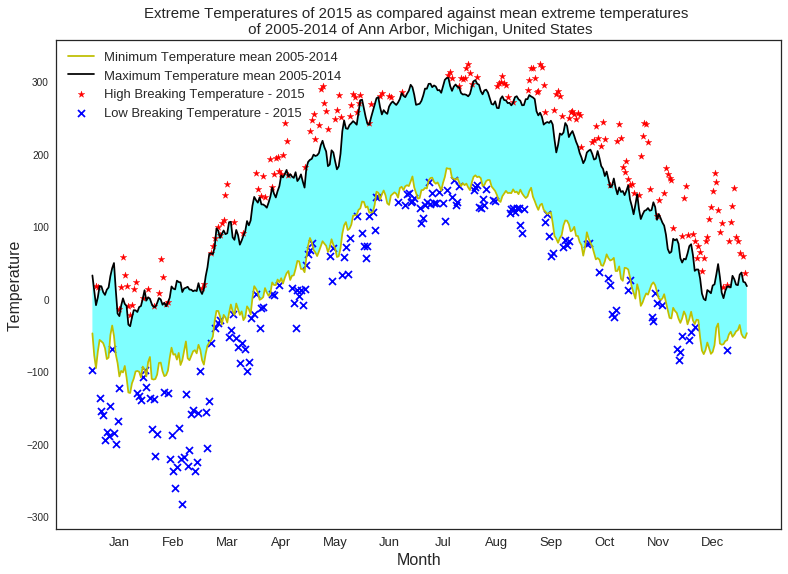

In [9]:
sns.set_style("white")
plt.figure(figsize=(13,9))
# Plotting the lines for minimum and maximum
plt.plot(df_line_min.Temperature_min, color = 'y', label = 'Minimum Temperature mean 2005-2014');
plt.plot(df_line_max.Temperature_max, color = 'k', label = 'Maximum Temperature mean 2005-2014');
# filling the area between plots
plt.fill_between(x = range(len(df_line_max)), y1 = df_line_min.Temperature_min, y2 = df_line_max.Temperature_max,
                     facecolor='cyan', alpha=0.5)

# # Adding scatterplot
plt.scatter(x = df_scatter_max.index, y = df_scatter_max['breaking_extreme_max'] , marker = '*', color = 'r',
            label = 'High Breaking Temperature - 2015')
plt.scatter(x = df_scatter_min.index, y = df_scatter_min['breaking_extreme_min'], marker = 'x', color = 'b',
            label = 'Low Breaking Temperature - 2015')

days = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
mid_months = [i+15 for i in days]

month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.title("Extreme Temperatures of 2015 as compared against mean extreme temperatures \n of 2005-2014 of Ann Arbor, Michigan, United States", fontsize=15)
plt.xlabel('Month', fontsize=16);
plt.ylabel('Temperature', fontsize=16);
plt.legend(loc = 'upper left', fontsize = 13);
plt.xticks(mid_months, month_name, fontsize = 13);
plt.show();

## Example given

In [10]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')